# Lab 5: Spam Detection

**Deadline**: Thursday, March 12, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Karthik Bhaskar 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1_Tv4AXRjJcPv_f0ZY75ZnAC8sdnq8YHV

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [88]:
torch.manual_seed(10)

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [89]:
for line in open('SMSSpamCollection'):
  if line[0] == 'h':
    print(line)
    break

for line in open('SMSSpamCollection'):
  if line[0] == "s":
    print(line)
    break   

print("The label value for a spam message is spam, and the label value for a non-spam message is ham.")
    

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

The label value for a spam message is spam, and the label value for a non-spam message is ham.


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [90]:
spamCount = 0
hamCount = 0

for line in open('SMSSpamCollection'):
  if line[0] == 'h':
    hamCount += 1
  elif line[0] == "s":
    spamCount += 1

print("There are {} spam messages and {} ham messages".format(spamCount, hamCount))


There are 747 spam messages and 4827 ham messages


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:


1.   There are far less characters than words, so there is less memory requirement for storing the numerical identifiers/tokens for characters vs those for words. 
2.   Furthermore, the likelihood of seeing an unknown word is much higher than seeing an unknown character, so less <unk> tokens will need to be used - allowing the model to receive a better representation of the actual message as an input. This would help the model generalize to new messages which may contain words not part of the model's vocabulary. This is especially true for new spam messages which may contain mispelled words that the model hasn't seen before - in a word level RNN, those would just be replaced by <unk> tokens.

Disadvantages:


1.   Any message has more characters than words, so inputs to the model will be much longer in a character based RNN than in a word based RNN. This would require more computations to train the network.
2.   Since meaning is carried by words and not characters, character based RNNs would be less effective at recognizing the meaning of longer sequences of words since they would need to "remember" the relationships between like 20 characters vs a word model needing to "remember" the relationships between 4 words. In terms of spam detection, a phrase like "Can u send money" is very different from "The company is losing money" and the network could only detect that if it can capture the relationships between all those words/characters.





### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [0]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label

train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

If the dataset is not balanced (ie. there are many more ham messages than spam messages), then the model can easily achieve an extremely high training accuracy by doing nothing more than predicting every message as spam. As such, an unbalanced training set encourages the model to bias towards false negative misclassification errors. Balancing the training set means that, in order to achieve good performance on the training examples, the model needs to learn how to identify spam messages as well as ham messages.

In [0]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [0]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

`text_field.vocab.stoi` is a dictionary mapping each character that appeared in the training set to a numerical identifier, and `text_field.vocab.itos` is a list of the characters in the training set in order of their respective numerical identifiers. 

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represents an unknown character that doesn't exist in the vocabulary (ie. it may represent a word that didn't appear often enough in the dataset so it was removed from the vocabulary), and `<pad>` is a token used to increase the size of SMS messages so that all SMS messages in a batch have the same length. 

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [0]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [95]:
i = 0
padCounts = [0, 0, 0, 0, 0, 0, 0, 0, 0 ,0] # The number of pad tokens in each batch
maxLengths = [0, 0, 0, 0, 0, 0, 0, 0, 0 ,0] # The maximum SMS length in that batch

for batch in train_iter:
  if i < 10:
    for sms in batch.sms[0]:
      if len(sms) > maxLengths[i]:
        maxLengths[i] = len(sms)
      for token in sms:
        if token == text_field.vocab.stoi["<pad>"]:
          padCounts[i] += 1
    i += 1     

print(padCounts) 
print(maxLengths)


[32, 39, 24, 23, 44, 30, 39, 14, 0, 19]
[44, 31, 38, 149, 90, 111, 57, 45, 158, 74]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [96]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [0]:
class RNN(nn.Module):
  def __init__(self, vocab_size, hidden_size, n_layers=1):
    super(RNN, self).__init__()

    # identity matrix for generating one-hot vectors
    self.ident = torch.eye(vocab_size)

    # recurrent neural network
    self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)

    # a fully-connected layer that classifies the input into SPAM/HAM
    self.classifier = nn.Linear(hidden_size, 2) 

  def forward(self, x):
    one_hot = []
    for sms in x:
      one_hot.append(self.ident[sms])   # generate one-hot vectors of input

    inp_x = torch.stack(one_hot)
    
    output, _ = self.rnn(inp_x)           # get the next output and hidden state
    out =  torch.max(output, dim=1)[0]    # max pooling the GRU output
    out = self.classifier(out)            # predict SPAM/HAM
    return out


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [0]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataloader `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for sms, labels in data:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [0]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    it = 0
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        avg_loss = 0
        for sms, labels in train:
            # target = sms[:, 1:]
            # inp = sms[:, :-1]
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        
        losses.append(float(loss))
        epochs.append(epoch+1)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.652703; Train Acc 0.567723; Val Acc 0.226009
Epoch 2; Loss 0.624810; Train Acc 0.575111; Val Acc 0.237668
Epoch 3; Loss 0.458548; Train Acc 0.922180; Val Acc 0.949776
Epoch 4; Loss 0.202245; Train Acc 0.907076; Val Acc 0.953363
Epoch 5; Loss 0.267677; Train Acc 0.917747; Val Acc 0.957848


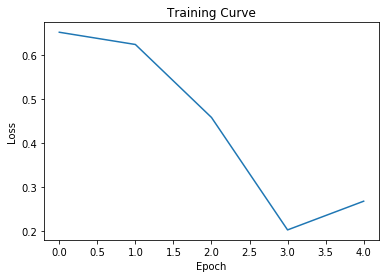

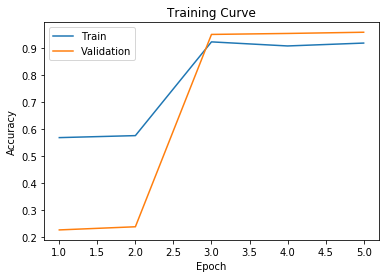

In [101]:
firstRNN = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=1)
train_rnn_network(firstRNN, train_iter, valid_iter, num_epochs=5, learning_rate=1e-4)

This initial model performed very well on the validation set, with an accuracy of almost 94%. Any improvements from here will likely be pretty incremental, but I will try to see what I can do from here.

In [0]:
torch.save(firstRNN.state_dict(), "first_model")

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

The 4 hyperparameters I will tune are the number of epochs, the learning rate, the number of layers in the GRU layer, and what I use as the input to the fully connected layer.

First, I increased the number of layers in the GRU (to 2) to see if that would improve performance at all. Since this would increase the number of weights in the neural network, I also increased the number of epochs to 10.

Results: 
```Epoch 10; Loss 0.347943; Train Acc 0.957642; Val Acc 0.953363```

The performance was very good, and it didn't appear to overfit the training set since the validation accuracy was as good (if not better) than the training accuracy for most of the epochs.

Next, I decided to try a slightly different architecture by using a concatenation of the max pooling and average pooling of the GRU output as the input to the fully connected layer. I kept everything else the same as the current model. The new class is declared below as "MyRNN".

Results: 
```Epoch 10; Loss 0.344888; Train Acc 0.962075; Val Acc 0.949776```

It was better on the training set but slightly worse on the validation set. However, I think it might have been a little bit overfit since it converged near those values really quickly. I decided to try again with a higher learning rate (5e-4) to avoid local minima.

Results:
```Epoch 10; Loss 0.375822; Train Acc 0.966015; Val Acc 0.969507```

This was the best performing model yet, but it appeared to converge at around 5 epochs and the other 5 epochs past that were overfitting with just extremely small gains in accuracy. So I decided to try training the same model but only for 5 epochs this time.

Results:
```Epoch 5; Loss 0.314648; Train Acc 0.960598; Val Acc 0.963229```

I decided to go with this model since it was just marginally below the numbers of the fourth model, but it was trained significantly less so it's less likely to be overfitted to the training data.


In [0]:
class MyRNN(nn.Module):
  def __init__(self, vocab_size, hidden_size, n_layers=1):
    super(MyRNN, self).__init__()

    # identity matrix for generating one-hot vectors
    self.ident = torch.eye(vocab_size)

    # recurrent neural network
    self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)

    # a fully-connected layer that classifies the input into SPAM/HAM
    self.classifier = nn.Linear(2*hidden_size, 2)  # 2*hidden_size because of the concatenated max/avg pooling - otherwise it would be 1*hidden_size

  def forward(self, x):
    one_hot = []
    for sms in x:
      one_hot.append(self.ident[sms])   # generate one-hot vectors of input

    inp_x = torch.stack(one_hot)
    
    output, _ = self.rnn(inp_x)          # get the next output and hidden state
    out = torch.cat([torch.max(output, dim=1)[0], torch.mean(output, dim=1)], dim=1)     # concatenate the max pooling and avg pooling of the GRU output
    out = self.classifier(out)          # predict SPAM/HAM
    return out


Epoch 1; Loss 0.037292; Train Acc 0.958463; Val Acc 0.957848
Epoch 2; Loss 0.068176; Train Acc 0.956493; Val Acc 0.968610
Epoch 3; Loss 0.033152; Train Acc 0.956986; Val Acc 0.973991
Epoch 4; Loss 0.025131; Train Acc 0.968150; Val Acc 0.975785
Epoch 5; Loss 0.104736; Train Acc 0.973403; Val Acc 0.965919


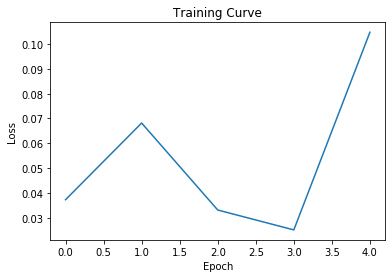

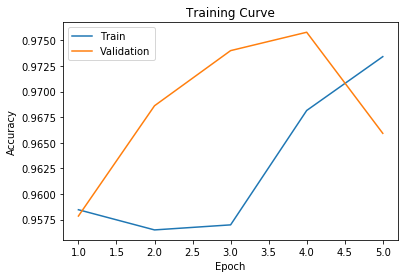

In [103]:
RNN_5 = MyRNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2)
train_rnn_network(RNN_5, train_iter, valid_iter, num_epochs=5, learning_rate=5e-4)

In [0]:
torch.save(RNN_5.state_dict(), "/content/fifth_model")

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [0]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [106]:
final_model = MyRNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=2)
state = torch.load("fifth_model")
final_model.load_state_dict(state)

<All keys matched successfully>

In [107]:
print("The model's false positive rate is {}.".format(1 - get_accuracy(final_model, valid_nospam_iter)))

print("The model's false negative rate is {}.".format(1 - get_accuracy(final_model, valid_spam_iter)))

The model's false positive rate is 0.02059732234809475.
The model's false negative rate is 0.09027777777777779.


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false positive would result in the phone blocking a valid message from the user. This could have a significant impact if the algorithm blocked an important message from an employer, or a doctor, or something like that. On the other hand, a false negative would mean that the user receives a spam message. This could be annoying, but the user is capable of deleting the spam message him/herself in that case so it isn't extremely impactful.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [109]:
print("The final test accuracy of my model is {}.".format(get_accuracy(final_model, test_iter)))

The final test accuracy of my model is 0.9685816876122083.


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [110]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print("The model's false positive rate is {}.".format(1 - get_accuracy(final_model, test_nospam_iter)))

print("The model's false negative rate is {}.".format(1 - get_accuracy(final_model, test_spam_iter)))

The model's false positive rate is 0.023735810113519107.
The model's false negative rate is 0.07586206896551728.


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [115]:
msg = "machine learning is sooo cool!"
msg_tokens = []

for char in msg:
  msg_tokens.append(torch.tensor(text_field.vocab.stoi[char]))

x = torch.stack(msg_tokens)
x.unsqueeze_(0)

print("According to my model, the probability that the SMS message is spam is {}.".format(F.softmax(final_model(x), dim=1)[0][1].item()))

According to my model, the probability that the SMS message is spam is 0.017946744337677956.


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

There have been decades of research on various methods to detect spam messages/emails, with plenty of different methods including neural networks, Naive Bayes Classifers, heuristic/word based filters, etc. Companies like Google and Microsoft have well tested, extremely advanced spam blocking engines that operate within their respective email services, and while they aren't perfect, they do work very well. As such, I would say that spam detection is one of the easier tasks that fall under the umbrella of "machine learning", especially when compared to tasks such as generating novel images/text, reinforcement learning, etc.

A baseline model for spam detection could be using a simple heuristic engine. Such a heuristic filter would work by scanning incoming emails for suspicious words (ex. "free" or "prince") and then assign points whenever it encounters a suspicous word or phrase. The database of suspicious words and phrases could be created by an expert, or just by parsing the spam dataset for words that commonly occur in that set and don't occur as much in the ham dataset.

